# Question 1(a)
Separate date and time for both pickup and dropoff, creating four new columns, 'pickup_date', 'pickup_time', 'dropoff_date','dropoff_time'.   
  
For the dates, keep only the day value as the Year  and month remains the same. Add the new columns to the existing DF. Display the first 5 rows from your DF.  [4 marks]

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [115]:
df = pd.read_csv('taxis.csv', encoding='unicode_escape')

# Question 1a
print("Question 1a")

# Convert pickup and dropoff columns into datetime 
df['pickup'] = pd.to_datetime(df['pickup'])
df['dropoff'] = pd.to_datetime(df['dropoff'])

# Extract day and time from pickup and dropoff columns
df['pickup_date'] = df['pickup'].dt.day
df['pickup_time'] = df['pickup'].dt.time
df['dropoff_date'] = df['dropoff'].dt.day
df['dropoff_time'] = df['dropoff'].dt.time

# Print top 5 rows, dropping pickup and dropoff temporarily
print("After spliting the date and time for pick and dropoff, here's the resultant df:\n")
print(df.head(5).to_string(header=True, index=False, col_space=10))

Question 1a
After spliting the date and time for pick and dropoff, here's the resultant df:

             pickup             dropoff  passengers   distance       fare        tip      tolls      total      color     payment           pickup_zone          dropoff_zone pickup_borough dropoff_borough  pickup_date pickup_time  dropoff_date dropoff_time
2019-03-23 20:21:09 2019-03-23 20:27:24           1       1.60        7.0       2.15        0.0      12.95     yellow credit card       Lenox Hill West   UN/Turtle Bay South      Manhattan       Manhattan           23    20:21:09            23     20:27:24
2019-03-04 16:11:55 2019-03-04 16:19:00           1       0.79        5.0       0.00        0.0       9.30     yellow        cash Upper West Side South Upper West Side South      Manhattan       Manhattan            4    16:11:55             4     16:19:00
2019-03-27 17:53:01 2019-03-27 18:00:25           1       1.37        7.5       2.36        0.0      14.16     yellow credit card       

# Question 1(b)
Compute the following for each car type- Green and Yellow.  [10 marks] 

i. Total fare, use the fare column in the DF  
ii. Total number of passengers travelled  
iii. Total distance travelled  
iv. Total time of travel.  (Days, Hours, Minutes, Seconds)

Hint: Look up the datetime python library.

In [116]:
# Question 1b 
print("Question 1b")

# Calculate the time of travel for each row and add it as a new column
df['travel_time'] = (df['dropoff'] - df['pickup'])

# Group by car_type and compute the totals
color_agg_results = df.groupby('color').agg({
    'fare': 'sum',
    'passengers': 'sum',
    'distance': 'sum',
    'travel_time': 'sum'
})

print("The aggregated results of fare, passengers, distance and travel_time for each colour is:")
print(color_agg_results.to_string(header=True, index=True, col_space=10))


Question 1b
The aggregated results of fare, passengers, distance and travel_time for each colour is:
                 fare  passengers   distance      travel_time
color                                                        
green        13788.15        1226    3345.95 10 days 15:37:46
yellow       70426.72        8676   16111.41 53 days 10:53:19


# Q2
Extract the details of the trip with the longest distance travelled for each of color of cars (green and yellow). Do this for each of the pickup dates shown below where a customer paid using cash.  
  
Dates: 10, 15, 20, 25, and 30.   
  
If none for any case, return a 0. Display your output in  a new dataframe named GY_cash, which should only have the following
columns:   
  
Pickup_date, Color of the cab, distance travelled, pickup, 
pickup_date, pickup_time, dropoff, dropoff_date, dropoff_time, and the fare.   
  
[10 marks]

In [117]:
# Question 2
print("Question 2")
# Filter for cash payments and specific pickup dates
cash_df = df[(df['payment'] == 'cash') & (df['pickup_date']).isin([10, 15, 20, 25, 30])]

# Function to get row with max distance for each group
def get_max_distance_trip(group):
    idx = group['distance'].idxmax() 
    if pd.notna(idx):  # checks if idx is not NaN
        return group.loc[idx]
    else:
        return pd.Series({'distance': 0})

# Group by car color and pickup date, then apply the function
max_distance_df = cash_df.groupby(['color', 'pickup_date']).apply(get_max_distance_trip)

# Filter and rearrange columns
GY_cash = max_distance_df[['color', 'distance', 'pickup', 'pickup_date', 'pickup_time', 'dropoff', 'dropoff_date', 'dropoff_time', 'fare']]
GY_cash.columns = ['color', 'distance', 'pickup', 'pickup_date', 'pickup_time', 'dropoff', 'dropoff_date', 'dropoff_time', 'fare']

GY_cash = GY_cash.reset_index(drop=True)

print("Longest distance on date 10, 15, 20, 25 and 30 for each color cab: ")
print(GY_cash.to_string(header=True, index=False, col_space=10))

Question 2
Longest distance on date 10, 15, 20, 25 and 30 for each color cab: 
     color   distance              pickup  pickup_date pickup_time             dropoff  dropoff_date dropoff_time       fare
     green      16.01 2019-03-10 00:59:49           10    00:59:49 2019-03-10 01:36:25            10     01:36:25       47.0
     green       4.71 2019-03-15 06:42:17           15    06:42:17 2019-03-15 06:54:38            15     06:54:38       15.0
     green       6.66 2019-03-20 12:04:33           20    12:04:33 2019-03-20 12:28:07            20     12:28:07       20.0
     green       8.80 2019-03-25 10:10:11           25    10:10:11 2019-03-25 10:46:25            25     10:46:25       31.0
     green      10.32 2019-03-30 09:25:32           30    09:25:32 2019-03-30 09:54:33            30     09:54:33       31.0
    yellow      11.52 2019-03-10 00:13:12           10    00:13:12 2019-03-10 00:33:09            10     00:33:09       32.5
    yellow      15.64 2019-03-15 16:45:55     

# Q3
From your GY_cash, identify by extracting the information on which color cab travelled larger distance on each pickup date with the corresponding distance information. Display your result in a new dataframe named GY_maxDist.  
  
A typical row of this DF should be:  
[Pickup_date, Color of the cab, distance travelled, pickup, pickup_date, pickup_time, dropoff, dropoff_date, dropoff_time, fare]   
  
[6 marks] 


In [118]:
# Question 3
print("Question 3")

# Group by 'pickup_date' and find the index with the maximum 'distance'
idx = GY_cash.groupby('pickup_date')['distance'].idxmax()

# Create a new dataframe with only the rows with the maximum 'distance' for each 'pickup_date'
GY_maxDist = GY_cash.loc[idx]

# Display the new DataFrame
print("Showing trip details of cabs with longest distances on pickup date of 10, 15, 20, 25, 30: ")
print(GY_maxDist.to_string(header=True, index=False, col_space=10))

Question 3
Showing trip details of cabs with longest distances on pickup date of 10, 15, 20, 25, 30: 
     color   distance              pickup  pickup_date pickup_time             dropoff  dropoff_date dropoff_time       fare
     green      16.01 2019-03-10 00:59:49           10    00:59:49 2019-03-10 01:36:25            10     01:36:25       47.0
    yellow      15.64 2019-03-15 16:45:55           15    16:45:55 2019-03-15 17:46:47            15     17:46:47       50.0
    yellow      17.01 2019-03-20 17:22:33           20    17:22:33 2019-03-20 18:07:19            20     18:07:19       52.0
    yellow      12.12 2019-03-25 05:33:43           25    05:33:43 2019-03-25 05:58:38            25     05:58:38       35.5
    yellow      17.14 2019-03-30 14:56:08           30    14:56:08 2019-03-30 15:49:32            30     15:49:32       52.0


# Q4
Write a function to calculate the actual speed in meters per second of the vehicle.  Given  the  distance,  start  time  and  end  time.  Assume  that  the distances  given  are  in  kilometers.  Use  the  apply  method  in  pandas  to  apply  the  function  to  GY_maxDist  and  create  a  new  column  with  this information called speed. Display your GY_maxDist DF.  
   
[7 marks]

In [119]:
# Question 4
print("Question 4")

# Function to calculate speed
def calculate_speed(row):
    # Convert date and time columns to datetime objects
    pickup_datetime = row['pickup']
    dropoff_datetime = row['dropoff']

    # Convert distance from kilometers to meters
    distance_m = row['distance'] * 1000
    
    # Calculate time difference in seconds
    time_difference = (dropoff_datetime - pickup_datetime).total_seconds()
    
    # Handle cases where time_difference is zero to avoid division by zero error
    if time_difference == 0:
        return 0
    
    # Calculate speed in meters per second
    speed = distance_m / time_difference

    return speed

# Applying the function to calculate speed
GY_maxDist['speed'] = GY_maxDist.apply(calculate_speed, axis=1)

print("GY_maxDist showing the actual speed in m/s of the vehicle: ")
print(GY_maxDist.to_string(header=True, index=False, col_space=10))


Question 4
GY_maxDist showing the actual speed in m/s of the vehicle: 
     color   distance              pickup  pickup_date pickup_time             dropoff  dropoff_date dropoff_time       fare      speed
     green      16.01 2019-03-10 00:59:49           10    00:59:49 2019-03-10 01:36:25            10     01:36:25       47.0   7.290528
    yellow      15.64 2019-03-15 16:45:55           15    16:45:55 2019-03-15 17:46:47            15     17:46:47       50.0   4.282585
    yellow      17.01 2019-03-20 17:22:33           20    17:22:33 2019-03-20 18:07:19            20     18:07:19       52.0   6.332837
    yellow      12.12 2019-03-25 05:33:43           25    05:33:43 2019-03-25 05:58:38            25     05:58:38       35.5   8.107023
    yellow      17.14 2019-03-30 14:56:08           30    14:56:08 2019-03-30 15:49:32            30     15:49:32       52.0   5.349563


# Q5
Using the DF from Q1, starting from 'Brooklyn’ borough and dropping off in ‘Manhattan’ borough, how many trips were made with the pickup date between the dates 10th March and 25th March? For each of these trips, compute the actual speed of the cars and output the mean speed of green cars and mean speed of yellow cars.   
  
Note that the dates are inclusive (include 10 and 25 March)

[5 marks]

In [120]:
# Question 5
print("Question 5")

# Filter the dataset for the specified conditions
filtered_df = df[
    (df['pickup_borough'] == 'Brooklyn') & 
    (df['dropoff_borough'] == 'Manhattan') & 
    (df['pickup_date'] >= 10) & 
    (df['pickup_date'] <= 25)].copy()

filtered_df['speed'] = filtered_df.apply(calculate_speed, axis=1)

# Calculate the mean speed for green and yellow cars
mean_speeds = filtered_df.groupby('color')['speed'].mean()

# Print number of trips
print("Number of trips made with the pickup date between the dates 10th March and 25th March: ")
print(len(filtered_df))

# Print mean speeds
print()
print("Mean speed of each color cab:")
print(mean_speeds.to_string(header=True, index=True))


Question 5
Number of trips made with the pickup date between the dates 10th March and 25th March: 
28

Mean speed of each color cab:
color
green     3.357360
yellow    4.203138


# Q6 
Between 2.30pm and 4pm on March 17th, which color cars had more pick ups?  

[Note that dates are inclusive]
  
[4 marks]
  


In [121]:
# Question 6
print("Question 6")

# Define the start and end time
start_time = pd.to_datetime('2019-03-17 14:30:00', format='%Y-%m-%d %H:%M:%S')
end_time = pd.to_datetime('2019-03-17 16:00:00', format='%Y-%m-%d %H:%M:%S')

# Filter the dataframe for the specified date and time range
filtered_df = df[ 
    (df['pickup'] >= start_time) & 
    (df['pickup'] <= end_time)
]

# Group by 'color' and count the number of pickups for each color
color_pickup_counts = filtered_df.groupby('color')['pickup_time'].count()

# Find the color with the maximum number of pickups
print("Number of pickups per color: ")
print(color_pickup_counts.to_string(header=False, index=True))
most_pickups_color = color_pickup_counts.idxmax()

print(f"The color with the most pickups between 2:30 pm and 4:00 pm on March 17th was: {most_pickups_color}")


Question 6
Number of pickups per color: 
green      2
yellow    14
The color with the most pickups between 2:30 pm and 4:00 pm on March 17th was: yellow


# Q7
Use your original taxis.csv dataset. Compute the following and report in a single dataframe:   
  
Compute the minimum, maximum, and the total number of passengers served from  each of the pickup zones. Also 
compute the respective minimum, maximum, and the total fare for each zone. Display the first 5 rows of the dataframe.  

[3 marks]

In [122]:
# Question 7
print("Question 7")

# Group the data by pickup zone and calculate the required statistics
result_df = df.groupby('pickup_zone').aggregate({
    'passengers': ['sum', 'min', 'max'],
    'fare': ['sum', 'min', 'max'],
    }
)

# Display the first 5 rows of the resulting dataframe
print(result_df.head().to_string(header=True, index=True, col_space=10))



Question 7
                        passengers                             fare                      
                               sum        min        max        sum        min        max
pickup_zone                                                                              
Allerton/Pelham Gardens          2          1          1      64.66       10.5      54.16
Alphabet City                   11          1          2     107.50        5.0      28.50
Astoria                        102          1          6     514.50        2.5      36.50
Auburndale                       1          1          1      21.40       21.4      21.40
Battery Park                     6          6          6      19.00       19.0      19.00


# Q8

Using the original data, for each pickup_zone , compute the following for each color of the cab and store this as two DFs, one for each color of the car (Yellow_stats_df, Green_stats_df) [10 marks]:   
 
a.  Number of trips starting from a pickup_zone  
  
b.  Total number of passengers travelled from that zone  
  
c.  Total distance travelled from that zone  
  
d.  Total  fare  (captured  in  the  'fare'  col)  each  zone  yields  to  that  car company (green or yellow)  
  
e.  Total fuel cost for each zone that a company needs to invest.  
i. To compute the total fuel cost, assume that a car (Yellow and Green)  on  an  average  consumes  fuel  around  5.5L  per  100 kms and cost per litre is, say, $3.  
ii. Example: Actual dist travelled in a trip = 39.5 kms; Then the total fuel consumed in litres = (39.5 * 5.5 / 100) = 2.1725 L; Thus, the total fuel cost for this trip = 2.1725 * 3 = $6.5175


In [127]:
# Question 8
print("Question 8")

# Calculate fuel cost
df['fuel_cost'] = (df['distance'] * 5.5 * 3 / 100)
# Group the data by color, pickup zone and calculate the required statistics
# https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.NamedAgg.html
stats_q8 = df.groupby(['color', 'pickup_zone']).agg(
    num_trips=pd.NamedAgg(column='pickup', aggfunc='count'),
    total_passengers=pd.NamedAgg(column='passengers', aggfunc='sum'),
    total_distance=pd.NamedAgg(column='distance', aggfunc='sum'),
    total_fare=pd.NamedAgg(column='fare', aggfunc='sum'),
    total_fuel_cost=pd.NamedAgg(column='fuel_cost', aggfunc='sum'),
)

# Split the data into two separate DataFrames based on the color
Yellow_stats_df = stats_q8.loc['yellow'].reset_index()
Green_stats_df = stats_q8.loc['green'].reset_index()

# Display the top 5 rows of each DataFrame
print("From the color yellow:")
print(Yellow_stats_df.head().to_string(header=True, index=True, col_space=10))
print("\nFrom the color green:")
print(Green_stats_df.head().to_string(header=True, index=True, col_space=10))


Question 8
From the color yellow:
                  pickup_zone  num_trips  total_passengers  total_distance  total_fare  total_fuel_cost
0               Alphabet City          9                11           25.17       107.5          4.15305
1                     Astoria         13                18           23.38       109.0          3.85770
2                Battery Park          1                 6            5.39        19.0          0.88935
3           Battery Park City         43                59          174.16       681.5         28.73640
4                     Bedford          1                 1            5.80        22.0          0.95700

From the color green:
                        pickup_zone  num_trips  total_passengers  total_distance  total_fare  total_fuel_cost
0           Allerton/Pelham Gardens          2                 2           23.09       64.66          3.80985
1                           Astoria         52                84           81.49      405.50       

# Q9
Then using your DFs  in Q8 above, compute the following for Green and Yellow car: [8 Marks] 
a.  Total number of passengers travelled  
b.  Total distance travelled  
c.  Total fare  
d.  Total fuel cost for the month for that company


In [136]:
# Question 9
print("Question 9")

# Compute the total stats for yellow cabs
yellow_total_passengers = Yellow_stats_df['total_passengers'].sum()
yellow_total_distance = Yellow_stats_df['total_distance'].sum()
yellow_total_fare = Yellow_stats_df['total_fare'].sum()
yellow_total_fuel_cost = Yellow_stats_df['total_fuel_cost'].sum()

# Compute the total stats for green cabs
green_total_passengers = Green_stats_df['total_passengers'].sum()
green_total_distance = Green_stats_df['total_distance'].sum()
green_total_fare = Green_stats_df['total_fare'].sum()
green_total_fuel_cost = Green_stats_df['total_fuel_cost'].sum()

# Print the results
print("Yellow cabs:")
print(f"Total number of passengers travelled: {yellow_total_passengers}")
print(f"Total distance travelled: {yellow_total_distance:.2f} kms")
print(f"Total fare: ${yellow_total_fare:.2f}")
print(f"Total fuel cost: ${yellow_total_fuel_cost:.2f}")

print("\nGreen cabs:")
print(f"Total number of passengers travelled: {green_total_passengers}")
print(f"Total distance travelled: {green_total_distance:.2f} kms")
print(f"Total fare: ${green_total_fare:.2f}")
print(f"Total fuel cost: ${green_total_fuel_cost:.2f}")

# # Display the new DataFrame
# print(Yellow_stats_df.sum())
# print(Green_stats_df.sum())


Question 9
Yellow cabs:
Total number of passengers travelled: 8649
Total distance travelled: 16058.77 kms
Total fare: $69781.22
Total fuel cost: $2649.70

Green cabs:
Total number of passengers travelled: 1222
Total distance travelled: 3345.95 kms
Total fare: $13760.65
Total fuel cost: $552.08


# Q10 (a)
Plot  the  top  10  pickup  zones  by  total  fare  using  the  following statistics from your Dfs in Q8.  

a.  Sort the pickup zones by total fare in descending order. Determine the top 10 pickup zones by total fare for each of the DFs in Q8. [5 marks] 



In [137]:
# Question 10a
print("Question 10a")

# Sort the pickup zones by total fare in descending order and get the top 10 zones for yellow cabs
top10_yellow_pickup_zones = Yellow_stats_df.sort_values(by='total_fare', ascending=False).head(10)

# Reset the index to start from 1 instead of 0
top10_yellow_pickup_zones.reset_index(drop=True, inplace=True)
top10_yellow_pickup_zones.index += 1

# Sort the pickup zones by total fare in descending order and get the top 10 zones for green cabs
top10_green_pickup_zones = Green_stats_df.sort_values(by='total_fare', ascending=False).head(10)

# Reset the index to start from 1 instead of 0
top10_green_pickup_zones.reset_index(drop=True, inplace=True)
top10_green_pickup_zones.index += 1

# Display the top 10 pickup zones for yellow and green cabs
print("Top 10 pickup zones for yellow cabs:")
print(top10_yellow_pickup_zones.to_string(header=True, index=True, col_space=10))

print("\nTop 10 pickup zones for green cabs:")
print(top10_green_pickup_zones.to_string(header=True, index=True, col_space=10))


Question 10a
Top 10 pickup zones for yellow cabs:
                             pickup_zone  num_trips  total_passengers  total_distance  total_fare  total_fuel_cost
1                            JFK Airport        151               240         2279.29     6713.06        376.08285
2                      LaGuardia Airport        146               246         1353.03     4457.00        223.24995
3                         Midtown Center        230               362          597.57     2870.50         98.59905
4           Penn Station/Madison Sq West        210               324          461.88     2460.00         76.21020
5              Times Sq/Theatre District        184               317          495.17     2291.56         81.70305
6                           Clinton East        208               330          429.75     2180.00         70.90875
7                           Midtown East        198               327          443.48     2177.00         73.17420
8                    Lincoln S

# Q10 (b)  
Bar Charts: for each color car, using the top 10 pickup zones, plot a  bar  chart  for  each  of  the  following  statistics.  You  may  decide  if you wish to plot group bar charts or w.r.t zones, etc. [12 marks]

i. Total number of passengers travelled  
ii. Total distance travelled  
iii. Total fare  
iv. Number of trips made  


Question 10b
Bar Graph for Yellow Cars:


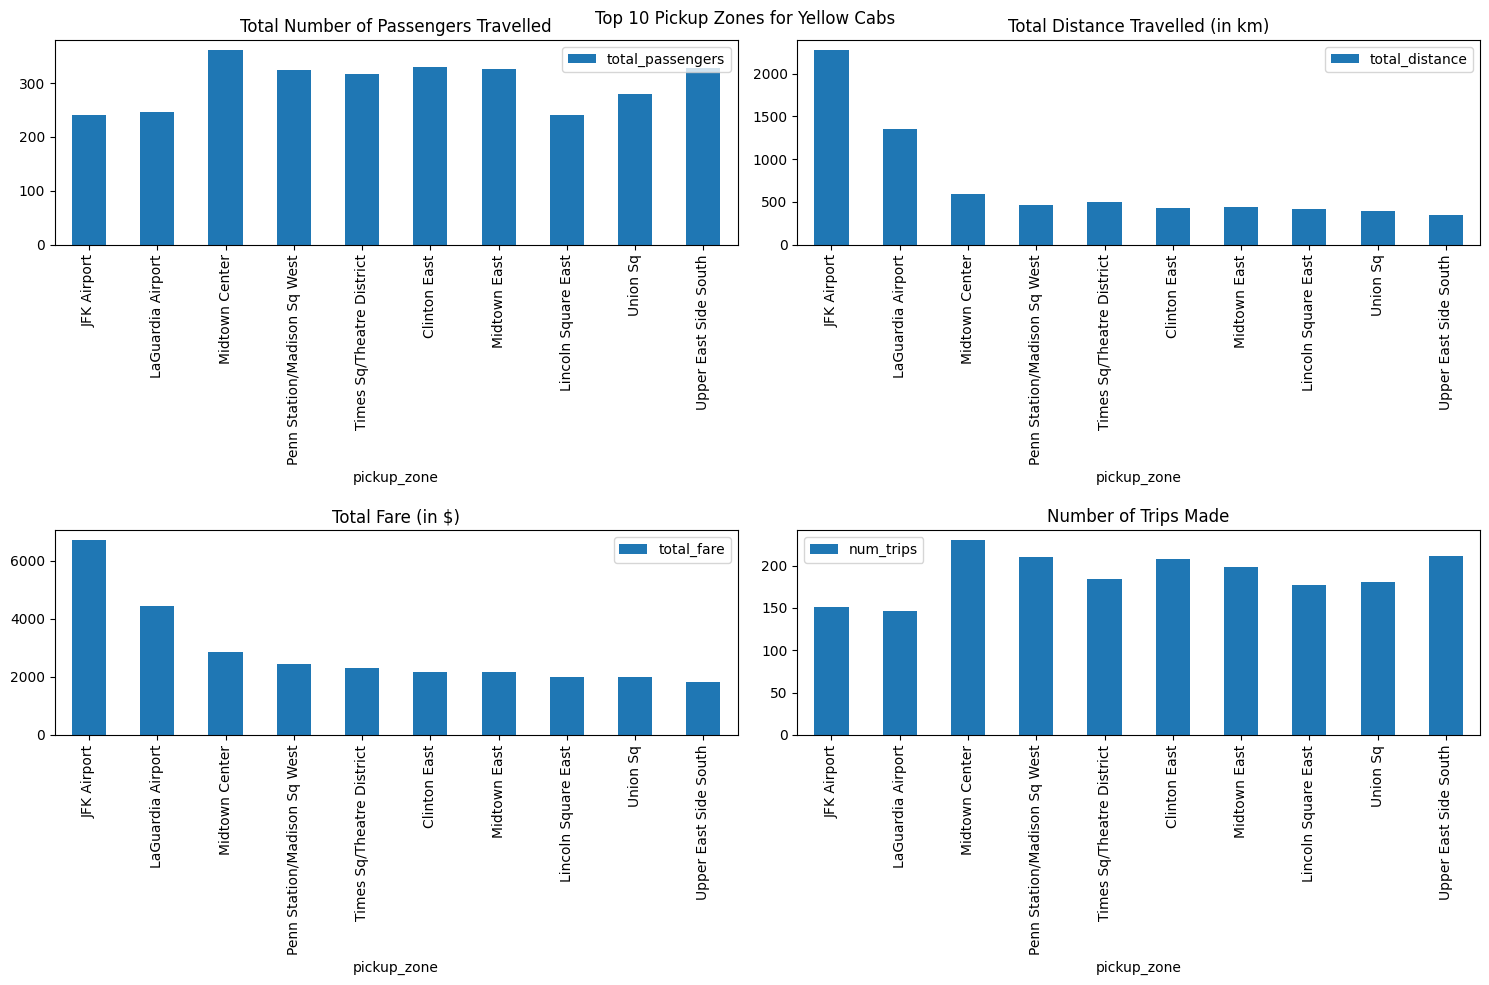

Bar Graph for Green Cars:


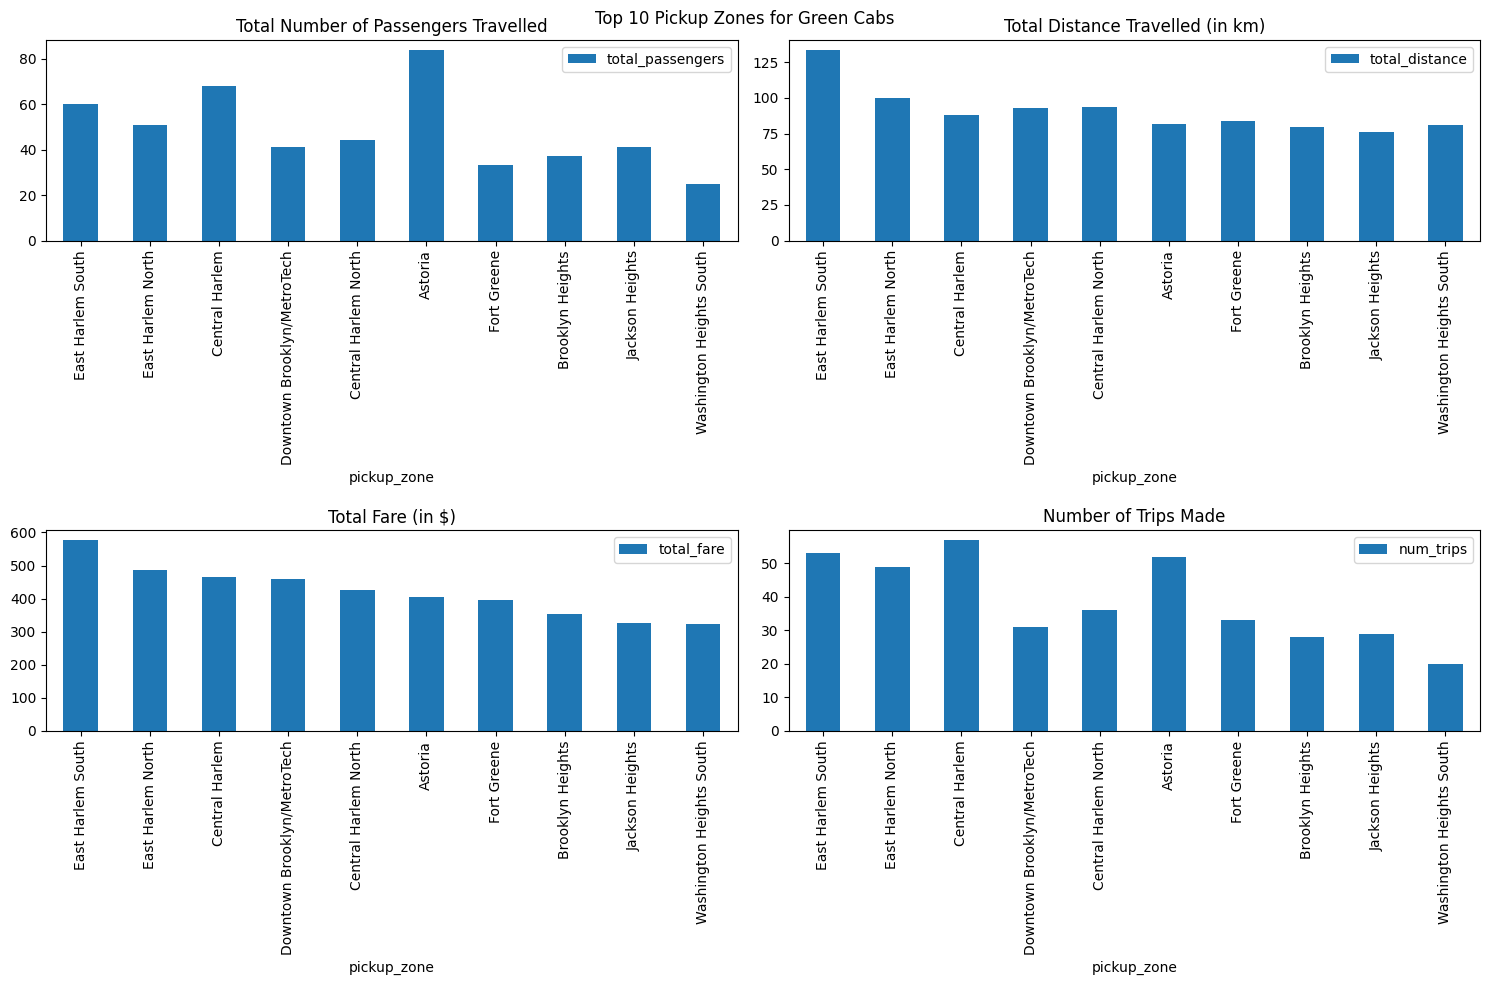

In [138]:
# Question 10b
print("Question 10b")
import matplotlib.pyplot as plt

# (After you have created your Yellow_stats_df and Green_stats_df as mentioned in the previous parts of your question...)

# Define a function to create bar charts for the specified statistics
def create_bar_charts(df, color):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Top 10 Pickup Zones for {color.capitalize()} Cabs')

    # Total number of passengers travelled
    df.plot(kind='bar', x='pickup_zone', y='total_passengers', ax=axes[0, 0])
    axes[0, 0].set_title('Total Number of Passengers Travelled')
    
    # Total distance travelled
    df.plot(kind='bar', x='pickup_zone', y='total_distance', ax=axes[0, 1])
    axes[0, 1].set_title('Total Distance Travelled (in km)')
    
    # Total fare
    df.plot(kind='bar', x='pickup_zone', y='total_fare', ax=axes[1, 0])
    axes[1, 0].set_title('Total Fare (in $)')
    
    # Number of trips made
    df.plot(kind='bar', x='pickup_zone', y='num_trips', ax=axes[1, 1]) 
    axes[1, 1].set_title('Number of Trips Made')
    
    # Adjust layout to prevent labels from overlapping
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    plt.show()

# Create bar charts for the top 10 pickup zones for yellow and green cabs
print("Bar Graph for Yellow Cars:")
create_bar_charts(top10_yellow_pickup_zones, 'yellow')
print("Bar Graph for Green Cars:")
create_bar_charts(top10_green_pickup_zones, 'green')


# Q10 C

Pie Chart: for each color car, plot a pie chart of the total cost fare each zone yields and another pie chart of the total fuel cost for each zone [8 marks] 

Question 10c


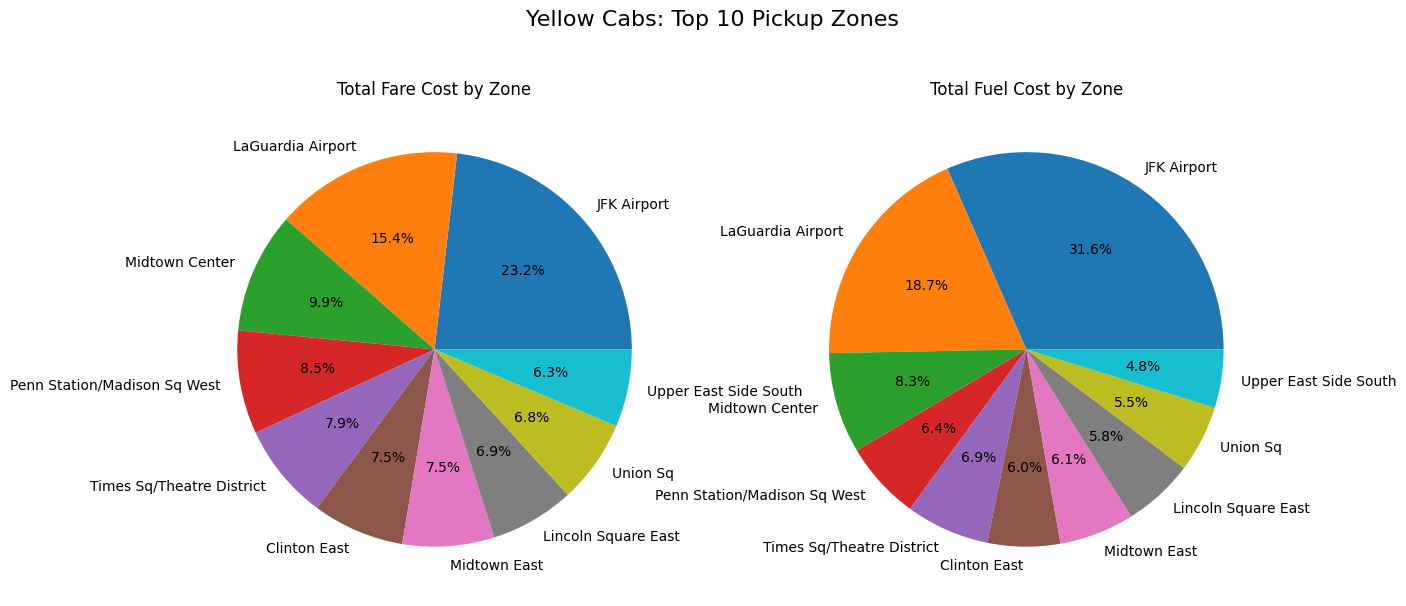

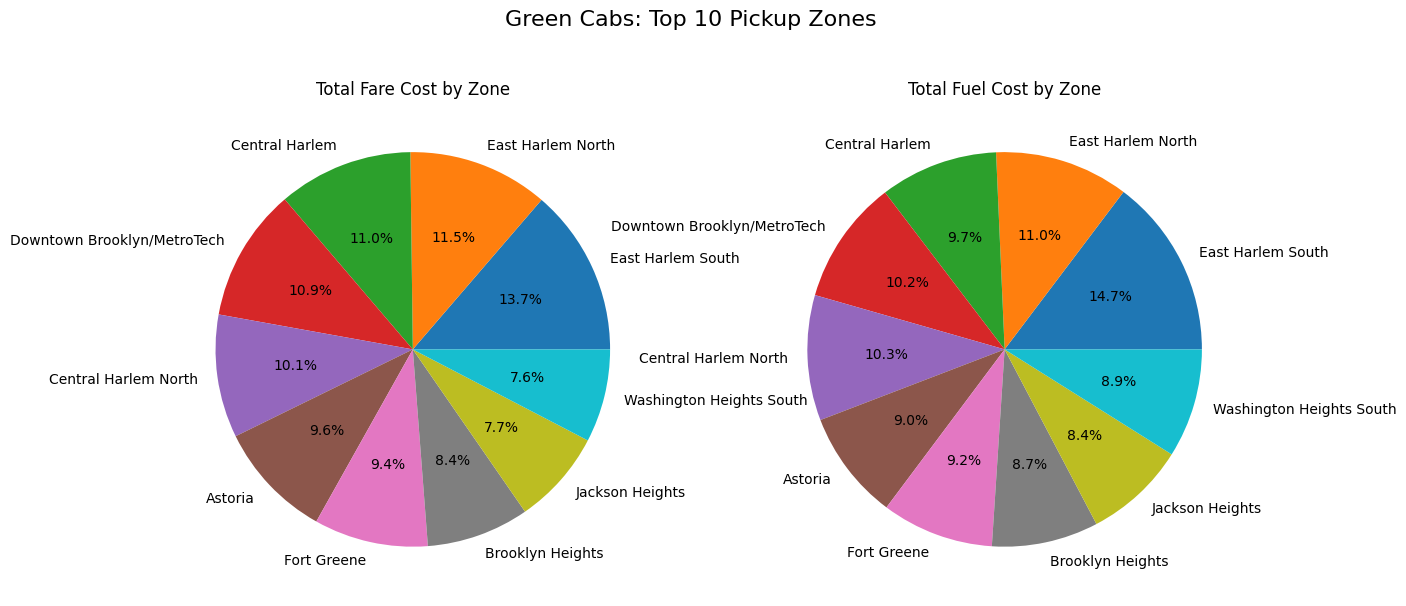

In [139]:
# Question 10c
print("Question 10c")
# Assuming that we're referring to the top 10 pickup zones (which is not explicitly stated in the question)

# Define a function to create pie charts for the specified statistics
def create_pie_charts(df, color):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # Pie chart for total fare cost
    df.plot(kind='pie', y='total_fare', labels=df['pickup_zone'], autopct='%1.1f%%', ax=axes[0], legend=False, fontsize=10)
    axes[0].set_ylabel('')
    axes[0].set_title('Total Fare Cost by Zone')
    
    # Pie chart for total fuel cost
    df.plot(kind='pie', y='total_fuel_cost', labels=df['pickup_zone'], autopct='%1.1f%%', ax=axes[1], legend=False, fontsize=10)
    axes[1].set_ylabel('')
    axes[1].set_title('Total Fuel Cost by Zone')

    # Set the main title for the whole figure
    fig.suptitle(f'{color.capitalize()} Cabs: Top 10 Pickup Zones', fontsize=16)
    
    # Display the pie charts
    plt.show()

# Create pie charts for the top 10 pickup zones for yellow and green cabs
create_pie_charts(top10_yellow_pickup_zones, 'yellow')
create_pie_charts(top10_green_pickup_zones, 'green')
